Importando as bibliotecas necessárias

In [1]:
import numpy as np
import pandas as pd
import datetime
from datetime import datetime
from datetime import timedelta
from bcb import Expectativas
import ipeadatapy as ip
from matplotlib import pyplot as plt
import seaborn as sns

Criando funções para manipulação de datas necessárias conexão com BCB Expectativas

In [2]:
# Cria função para subtrair os dias do ano

def years_sub(days = 10 * 365):
  sub_year_days = pd.to_datetime(datetime.today().strftime('%Y-%m-%d')) - timedelta(days)
  sub_year_days = sub_year_days.strftime("%Y-%m-%d")
  return sub_year_days

# Cria função para calcular a data de referência a partir da data de observação

def reference_date(date):
  years = pd.DatetimeIndex(date).year.values + 3 # Calcula 3 anos a frente
  years = years.tolist()
  years = [str(i) for i in years]
  return years

In [3]:
years_sub(days=10*365)

'2014-04-02'

Coletando dados de expectativas da inflação do BCB Expectativas


In [4]:
em = Expectativas()
ep = em.get_endpoint('ExpectativasMercadoAnuais')

ipca_raw = (
  ep.query()
  .filter(ep.Indicador == "IPCA")
  .filter(ep.Data >= years_sub(days=10 * 365))
  .filter(ep.baseCalculo == 0)
  .select(ep.Data, ep.Mediana, ep.Minimo, ep.Maximo, ep.DataReferencia)
  .collect()
  )

# Realiza o filtro para a data de referência 3 anos a frente das obs.
ipca = ipca_raw[(
          ipca_raw
          .DataReferencia == reference_date(ipca_raw['Data'])
          )
            ]

# Renomeia as colunas
ipca = ipca.rename(columns = {'Data' : 'date',
                                  'Mediana' : 'ipca_e',
                                  'Minimo' : 'ipca_e_min',
                                  'Maximo' : 'ipca_e_max'}).drop(['DataReferencia'], axis = 1)
ipca

,date,ipca_e,ipca_e_min,ipca_e_max
1,2014-04-02,5.30,4.0,6.5
8,2014-04-03,5.35,4.0,6.5
14,2014-04-04,5.35,4.0,6.5
15,2014-04-07,5.40,4.0,6.5
20,2014-04-08,5.40,4.0,6.5
...,...,...,...,...
12493,2024-03-18,3.50,3.0,5.0
12498,2024-03-19,3.50,3.0,5.0
12503,2024-03-20,3.50,3.0,5.0
12508,2024-03-21,3.50,3.0,5.0


Coletando dados de expectativas da Selic do BCB Expectativas

In [5]:
Selic_raw = (
  ep.query()
  .filter(ep.Indicador == "Selic")
  .filter(ep.Data >= years_sub(days=10 * 365))
  .filter(ep.baseCalculo == 0)
  .select(ep.Data, ep.Mediana, ep.Minimo, ep.Maximo, ep.DataReferencia)
  .collect()
  )

# Realiza o filtro para a data de referência 3 anos a frente das obs.
selic = Selic_raw[(
          Selic_raw
          .DataReferencia == reference_date(Selic_raw['Data'])
          )
            ]

# Renomeia as colunas
selic = selic.rename(columns = {'Data' : 'date',
                                  'Mediana' : 'selic_e',
                                  'Minimo' : 'selic_e_min',
                                  'Maximo' : 'selic_e_max'}).drop(['DataReferencia'], axis = 1)
selic

,date,selic_e,selic_e_min,selic_e_max
1,2014-04-02,10.0,7.0,14.0
8,2014-04-03,10.0,7.0,14.0
14,2014-04-04,10.0,7.0,14.0
15,2014-04-07,10.0,7.0,14.0
20,2014-04-08,10.0,7.0,14.0
...,...,...,...,...
12493,2024-03-18,8.5,5.5,11.0
12498,2024-03-19,8.5,5.5,11.0
12503,2024-03-20,8.5,5.5,11.0
12508,2024-03-21,8.5,5.5,11.0


Declarando função de Fisher para converter Taxa Nominal em Taxa Real

In [6]:
def fisher(juros, inflacao):
  juros_neutro = ((((1 + (juros / 100)) / (1 + inflacao / 100))) -1) * 100
  return juros_neutro

Unificando Dataframes IPCA e Selic e calculando Taxa Selic Real com a equação de Fisher

In [7]:
proxy_neutro = pd.merge(left = ipca,
                        right = selic,
                        how = 'inner',
                        on = 'date')
proxy_neutro = proxy_neutro.assign(neutro = lambda x : fisher(x.selic_e, x.ipca_e),
                    neutro_min = lambda x : fisher(x.selic_e_min, x.ipca_e_min),
                    neutro_max = lambda x : fisher(x.selic_e_max, x.ipca_e_max))

proxy_neutro = proxy_neutro.set_index(pd.to_datetime(proxy_neutro['date']).dt.to_period('D')).drop(['date'], axis = 1)

# Realiza a mudança para período mensal com base na média dos valores
proxy_neutro_M = proxy_neutro.resample('M').mean()
proxy_neutro_M

,ipca_e,ipca_e_min,ipca_e_max,selic_e,selic_e_min,selic_e_max,neutro,neutro_min,neutro_max
date,,,,,,,,,
2014-04,5.373684,4.000000,6.500000,10.131579,7.000000,14.000000,4.515250,2.884615,7.042254
2014-05,5.435714,4.000000,6.500000,10.476190,7.000000,14.000000,4.780633,2.884615,7.042254
2014-06,5.500000,4.000000,6.500000,10.500000,7.000000,14.000000,4.739336,2.884615,7.042254
2014-07,5.500000,4.000000,6.500000,10.260870,7.000000,14.000000,4.512673,2.884615,7.042254
2014-08,5.500000,4.000000,6.500000,10.202381,7.000000,14.000000,4.457233,2.884615,7.042254
...,...,...,...,...,...,...,...,...,...
2023-11,3.500000,2.500000,5.235000,8.500000,5.000000,11.400000,4.830918,2.439951,5.859057
2023-12,3.500000,2.100000,5.000000,8.500000,3.950000,11.500000,4.830918,1.811949,6.190476
2024-01,3.500000,2.690909,5.005455,8.500000,4.590909,10.590909,4.830918,1.849414,5.319184


Coletando Taxas de juros dos contratos da Taxa referencial - swaps - DI x pré-fixada - 360 dias - média do período

In [8]:
pd.set_option('display.max_colwidth', None)
ipea_matadata = ip.metadata()
ipea_matadata.tail()

,CODE,NAME,COMMENT,LAST UPDATE,BIG THEME,SOURCE ACRONYM,SOURCE,SOURCE URL,FREQUENCY,MEASURE,UNIT,SERIES STATUS,THEME CODE,COUNTRY,NUMERICA
9614,SIS_NMLTINTSUS1000HUF,Número de leitos para internação pelo SUS por 10.000 habitantes,Número mensal médio de leitos de internação pelo SUS - Por 10.000 habitantes,2023-11-27T17:19:22.803-03:00,Social,SIS-IBGE,Síntese de Indicadores Sociais,https://www.ibge.gov.br/estatisticas/sociais/saude/9221-sintese-de-indicadores-sociais.html?=&t=resultados,Anual,-,None,None,106,BRA,True
9615,SIS_NMLTINTUF,Número de leitos para internação,Número mensal médio de leitos de internação - Total,2023-11-27T17:19:22.79-03:00,Social,SIS-IBGE,Síntese de Indicadores Sociais,https://www.ibge.gov.br/estatisticas/sociais/saude/9221-sintese-de-indicadores-sociais.html?=&t=resultados,Anual,-,None,None,106,BRA,True
9616,SIS_NMMED1000HUF,Médicos por 10.000 habitantes,Número mensal médio de médicos - Por 10.000 habitantes,2023-11-27T16:55:18.347-03:00,Social,SIS-IBGE,Síntese de Indicadores Sociais,https://www.ibge.gov.br/estatisticas/sociais/saude/9221-sintese-de-indicadores-sociais.html?=&t=resultados,Anual,-,None,None,106,BRA,True
9617,SIS_NMODN1000HUF,Odontólogos por 10.000 habitantes,Número mensal médio de odontólogos - Por 10.000 habitantes,2023-11-27T16:55:18.347-03:00,Social,SIS-IBGE,Síntese de Indicadores Sociais,https://www.ibge.gov.br/estatisticas/sociais/saude/9221-sintese-de-indicadores-sociais.html?=&t=resultados,Anual,-,,None,106,BRA,True
9618,SIS_NMTEC1000HUF,Técnicos e auxiliares de saúde por 10.000 habitantes,Número médio mensal de técnicos e auxiliares de saúde - Por 10.000 habitantes,2023-11-27T16:55:18.347-03:00,Social,SIS-IBGE,Síntese de Indicadores Sociais,https://www.ibge.gov.br/estatisticas/sociais/saude/9221-sintese-de-indicadores-sociais.html?=&t=resultados,Anual,-,None,None,106,BRA,True


In [9]:
ipea_matadata.query('CODE.str.contains("SWAP")')[['CODE','NAME']]

,CODE,NAME
7980,BMF12_SWAPDI18012,Taxa referencial - swaps - DI x pré-fixada - 180 dias - média do período
7981,BMF12_SWAPDI180F12,Taxa referencial - swaps - DI x pré-fixada - 180 dias - fim de período
7982,BMF12_SWAPDI36012,Taxa referencial - swaps - DI x pré-fixada - 360 dias - média do período
7983,BMF12_SWAPDI360F12,Taxa referencial - swaps - DI x pré-fixada - 360 dias - fim de período


In [10]:
swaps = (
    ip.timeseries('BMF12_SWAPDI36012')
    .rename(columns = {'VALUE ((% a.a.))' : 'swaps'})[['swaps']]
)

# Muda a coluna de data para o índice
swaps = swaps.set_index(swaps.index.to_period('M'))
swaps

,swaps
DATE,
1999-09,25.620000
1999-10,25.020000
1999-11,23.790000
1999-12,22.680000
2000-01,21.240000
...,...
2023-10,11.111905
2023-11,10.649500
2023-12,10.231053


Expectativa média do IPCA - tx. acumulada para os próximos 12 meses (Expectativas)

In [11]:
ifl_ep = em.get_endpoint('ExpectativasMercadoInflacao12Meses')

ipca_expec_12m_raw = (
    ifl_ep.query()
    .filter(ifl_ep.Suavizada == 'S', ifl_ep.baseCalculo == 0, ifl_ep.Indicador == 'IPCA')
    .collect()
    )


In [12]:
ipca_expec_12m = (
    ipca_expec_12m_raw
    .set_index(pd.to_datetime(ipca_expec_12m_raw['Data'])
    .dt.to_period('D'))
    .rename(columns = {'Mediana' : 'ipca_exp_12m'})
    [['ipca_exp_12m']]
                    )
# Mensaliza os dados com base na média dos valores
ipca_expec_12m = ipca_expec_12m.resample('M').mean()

In [13]:
ipca_expec_12m

,ipca_exp_12m
Data,
2001-12,5.030000
2002-01,4.733636
2002-02,4.644737
2002-03,4.721500
2002-04,4.790000
...,...
2023-11,3.928835
2023-12,3.896605
2024-01,3.862150


Unificando Dataframe de expectativas de inflação com Taxa dos contratos SWAP e calculando a Taxa Real dos contratos

In [14]:
ex_ante = ipca_expec_12m.join(swaps)

ex_ante = ipca_expec_12m.join(swaps)

# Calcula o juro real ex-ante
ex_ante = ex_ante.assign(juro_real = lambda x: fisher(x.swaps, x.ipca_exp_12m))
ex_ante.dropna(inplace=True)
ex_ante

,ipca_exp_12m,swaps,juro_real
Data,,,
2001-12,5.030000,21.330000,15.519375
2002-01,4.733636,20.480000,15.034677
2002-02,4.644737,19.910000,14.587703
2002-03,4.721500,18.650000,13.300516
2002-04,4.790000,18.910000,13.474568
...,...,...,...
2023-10,3.971710,11.111905,6.867440
2023-11,3.928835,10.649500,6.466603
2023-12,3.896605,10.231053,6.096876


Unificando Juros Neutro do 

In [15]:
df_juros = (
    proxy_neutro_M
    .join(ex_ante)
    [['juro_real', 'neutro']]
    .rename(columns = {'juro_real' : 'Taxa DI',
                                      'neutro' : 'Juro Neutro'})
      )
df_juros = df_juros.dropna()

# Muda a coluna de data para timestamp (para gerar o gráfico)
df_juros.index = df_juros.index.to_timestamp(freq='M')


# Transforma de wide para long (para facilitar na construção do grafico)
df_juros_long = pd.melt(df_juros.reset_index(),
                        id_vars = 'date',
                        value_vars = ['Taxa DI', 'Juro Neutro'],
                        var_name = 'variable',
                        value_name = 'values')
df_juros

,Taxa DI,Juro Neutro
date,,
2014-04-30,4.989179,4.515250
2014-05-31,5.032569,4.780633
2014-06-30,4.757364,4.739336
2014-07-31,4.663017,4.512673
2014-08-31,4.663333,4.457233
...,...,...
2023-10-31,6.867440,4.830918
2023-11-30,6.466603,4.830918
2023-12-31,6.096876,4.830918


Gerando visualização grafica das taxas

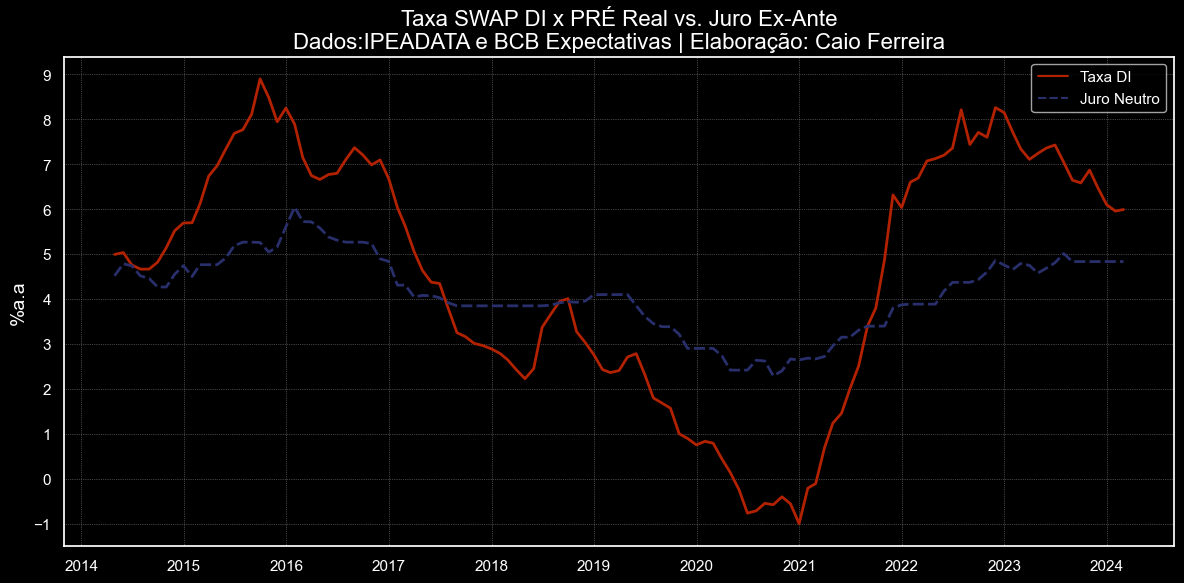

In [16]:
# Configurações do tema
theme = {'figure.figsize' : (12, 6)}

# Cores das variáveis
colors = ['#b22200', '#282f6b']
# Adiciona as configurações
sns.set_theme(style='darkgrid', palette=colors, rc=theme)
custom_style = {
    'axes.titlesize': 16,
    'axes.titlecolor': 'w',
    'axes.labelsize': 14,
    'axes.labelcolor': 'w',
    'figure.facecolor': 'black',
    'axes.facecolor': 'black',
    'xtick.color': 'w',
    'ytick.color': 'w',
    'grid.color': 'gray',
    'grid.linestyle': ':',
    'grid.linewidth': 0.5,
    'axes.autolimit_mode': 'data',
    'legend.labelcolor': 'w'
}
with plt.rc_context(rc=custom_style):
# Plote o gráfico de linhas
   sns.lineplot(data=df_juros,
               linewidth=2).set(xlabel="",
                               ylabel="%a.a",
                               title="Taxa SWAP DI x PRÉ Real vs. Juro Ex-Ante\nDados:" +
       "IPEADATA e BCB Expectativas | Elaboração: Caio Ferreira")
   
#Mostre o gráfico
plt.locator_params(axis='y', nbins=12)
plt.tight_layout()
plt.savefig('Charts/Juro Real e Neutro.png')
plt.show()
